In [1]:
# !pip install contractions
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install -U spacy
# !python -m spacy download en

#### Download raw data and unzip it.

In [2]:
# !wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00462/drugsCom_raw.zip"

In [3]:
# !unzip "drugsCom_raw.zip"

### Read the Source Data

In [5]:
import numpy as np
import pandas as pd

df = pd.read_table('/Users/kkvp639/Documents/codemania/contentfly/data/raw_data/drugsComTrain_raw.tsv')
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


#### Top 10 conditions.
- Get top 10 conditions based on its frequency.
- Mark all the remaining conditions to "OTHERS" category/condition.

<AxesSubplot:>

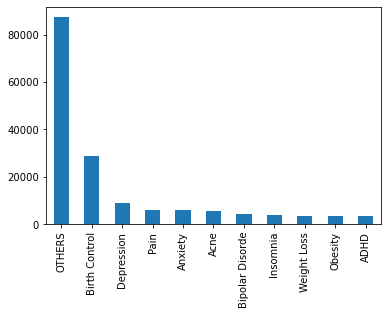

In [7]:
top_10_conditions = df['condition'].value_counts().head(10).index.tolist()
df['condition'] = df['condition'].apply(lambda x: x if x in top_10_conditions else 'OTHERS')
df['condition'].value_counts().plot(kind='bar')

Observations:
- As OTHERS condition is tagged with all the minority conditions and it rises its frequency. Will handle it later 

In [8]:
import re
import html
import contractions

def remove_chars(text):
    """
        Remove all the unneccessary special characaters.
    """
    text = html.unescape(text)
    text = contractions.fix(text)
    remove_chars_1 = r'[^A-Za-z0-9 ]'
    remove_chars_2 = r'^"'
    remove_chars_3 = r'"$'
    more_than_two_spaces = r'[\s\s]+'
    text = re.sub(remove_chars_1, ' ', text)
    text = re.sub(remove_chars_2, ' ', text)
    text = re.sub(remove_chars_3, ' ', text)
    text = re.sub(more_than_two_spaces, ' ', text)
    return text.strip()


df['cleaned_text'] = df['review'].apply(remove_chars)

In [9]:
import spacy

# Load the spacy model and disable unused features
spacy_model = spacy.load('en_core_web_sm')

In [10]:
def spacy_nouns_features(text):
    """
        Generate more features using the text.
    """
    text = spacy_model(text)
    token_features = {'norm_text': [], 'norm_text_counts': 0, 'noun_words': [], 'noun_counts': 0, 'stop_word_counts': 0, 'digits_counts': 0, 'lower_counts': 0, 'upper_counts': 0, 'title_counts': 0, 'total_words': 0, 'noun_phrase_counts': 0, 'noun_phrases': []}
    for token in text:
        if token.pos_ in ['NOUN', 'PROPN']:
            token_features['noun_counts'] += 1
            token_features['noun_words'].append(str(token))
        if token.is_digit:
            token_features['digits_counts'] += 1
        if token.is_lower and len(token) > 1:
            token_features['lower_counts'] += 1
        if token.is_upper and len(token) > 1:
            token_features['upper_counts'] += 1
        if token.is_title and len(token) > 1:
            token_features['title_counts'] += 1
        if token.is_stop:
            token_features['stop_word_counts'] += 1
        else:
            token_features['norm_text'].append(str(token.lemma_))

    token_features['total_words'] = len(text)
    token_features['noun_phrase_counts'] = len(list(text.noun_chunks))
    token_features['noun_phrases'] = [str(x) for x in list(text.noun_chunks)]
    token_features['norm_text_counts'] = len(token_features['norm_text'])
    token_features['norm_text'] = ' '.join(token_features['norm_text']).lower().strip()
        
    return token_features


df_spacy_vectors_nouns = df['cleaned_text'].apply(spacy_nouns_features)
# df_spacy_vectors_nouns = np.row_stack(df_spacy_vectors)
# df_spacy_vectors_nouns = pd.DataFrame(df_spacy_vectors)
# df_spacy_vectors_nouns.to_csv('df_spacy_vectors_nouns.csv', index=False) # saved
df_spacy_vectors_nouns.head()


0    {'norm_text': 'effect combination bystolic 5 m...
1    {'norm_text': 'son halfway fourth week intuniv...
2    {'norm_text': 'oral contraceptive 21 pill cycl...
3    {'norm_text': 'time form birth control glad go...
4    {'norm_text': 'suboxone completely turn life f...
Name: cleaned_text, dtype: object

In [13]:
for x in df_spacy_vectors_nouns:
    x['noun_phrases'] = [str(x) for x in x['noun_phrases']]
    x['norm_text'] = ' '.join([str(x) for x in x['norm_text'].split()])

In [49]:
import pickle

file_to_store = open("df_spacy_vectors_nouns.pkl", "wb")
pickle.dump(df_spacy_vectors_nouns_pkl_obj, file_to_store)
file_to_store.close()

In [50]:
# import pickle

# file_to_store = open("df_spacy_vectors_nouns.pkl", "rb")
# df_spacy_vectors_nouns_pkl_obj = pickle.load(file_to_store)
# file_to_store.close()

In [15]:
df_spacy_vectors_nouns_pkl_obj = [x for x in df_spacy_vectors_nouns]
len(df_spacy_vectors_nouns_pkl_obj)

161297

In [16]:
list_of_fs = []
for x in df_spacy_vectors_nouns_pkl_obj:
    f = {}
    f['norm_text'] = x['norm_text']
    f['norm_text_counts'] = x['norm_text_counts']
    f['noun_counts'] = x['noun_counts']
    f['stop_word_counts'] = x['stop_word_counts']
    f['digits_counts'] = x['digits_counts']
    f['total_words'] = x['total_words']
    f['noun_phrase_counts'] = x['noun_phrase_counts']
    list_of_fs.append(f)
len(list_of_fs)

161297

In [19]:
df_f = pd.DataFrame(list_of_fs)
df_f['condition'] = df['condition']

In [21]:
df_f['sentence_length'] = df_f["norm_text"].apply(lambda x: len(x.split()))

In [22]:
# df['length_bins'] = pd.cut(df['sentence_length'], bins=40)
cut_bins = [0, 1, 2, 5, 10, 20, 30, 50, 70, 100, 200, 300, 400, 500, 600, 700, 800, 900]
df_f['length_bins'] = pd.cut(df_f['sentence_length'], bins=cut_bins)

OTHERS


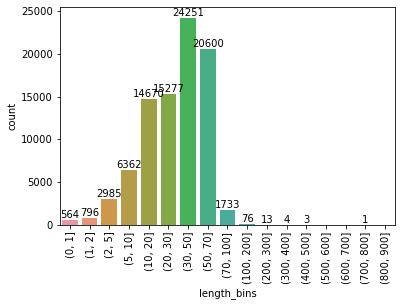

ADHD


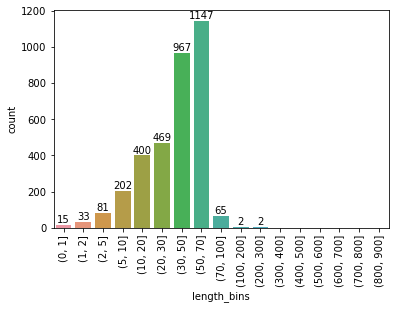

Birth Control


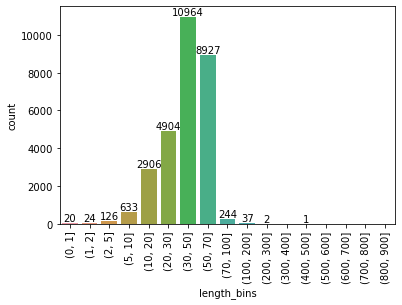

Bipolar Disorde


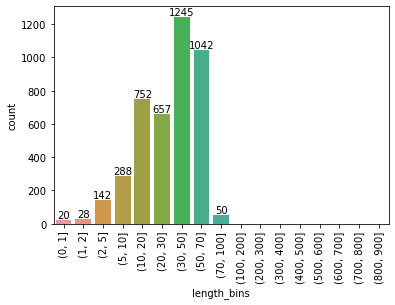

Depression


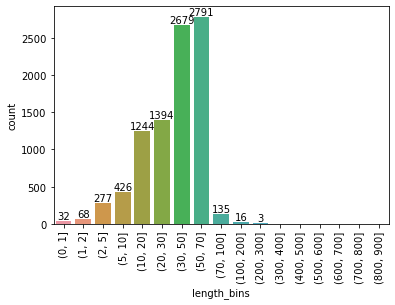

Obesity


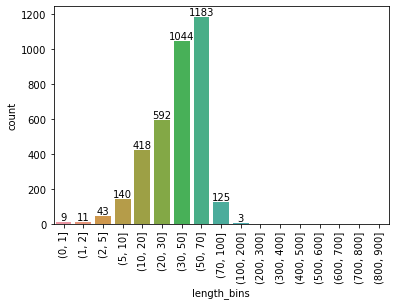

Insomnia


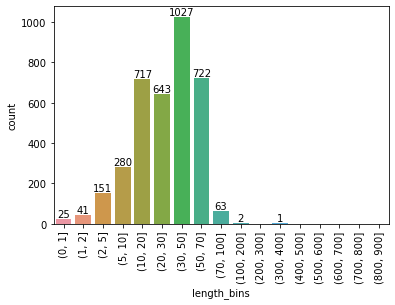

Pain


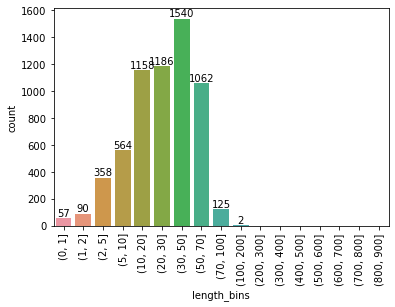

Anxiety


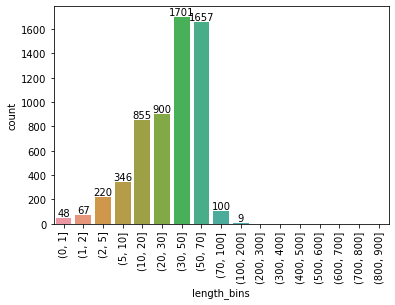

Acne


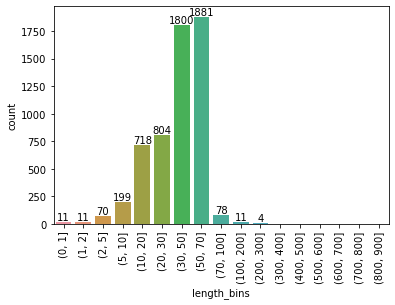

Weight Loss


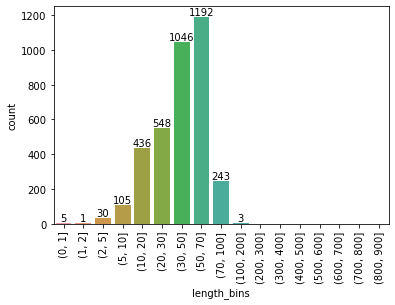

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

for condition in df_f['condition'].unique():
    print(condition)
    p = sns.countplot(x ='length_bins', data = df_f[df_f['condition'] == condition])
    p.set_xticklabels(p.get_xticklabels(), rotation=90) 
    p.bar_label(p.containers[0], label_type='edge')
    plt.show()


In [24]:
other_downsampled_indexes1 = df_f[(df_f['condition'] == 'OTHERS') & ((df_f['sentence_length'] >= 30) & (df_f['sentence_length'] < 50 ))].sample(frac=1)[7000:].index.tolist()
len(other_downsampled_indexes1)

17502

In [25]:
other_downsampled_indexes2 = df_f[(df_f['condition'] == 'OTHERS') & ((df_f['sentence_length'] >= 50) & (df_f['sentence_length'] < 70 ))].sample(frac=1)[7000:].index.tolist()
len(other_downsampled_indexes2)

14416

In [26]:
other_downsampled_indexes3 = df_f[(df_f['condition'] == 'OTHERS')].sample(frac=1)[40000:].index.tolist()
len(other_downsampled_indexes3)

47346

In [27]:
other_downsampled_indexes = list(set(other_downsampled_indexes1 + other_downsampled_indexes2 + other_downsampled_indexes3))
len(other_downsampled_indexes)

62029

In [28]:
df_f.drop(df_f.index[other_downsampled_indexes], inplace=True) # Drop indexes

<AxesSubplot:>

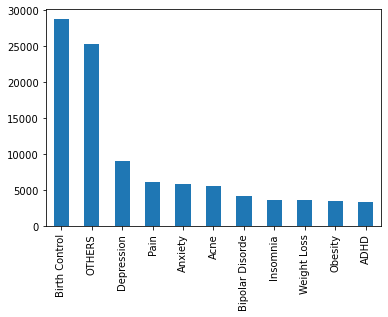

In [29]:
df_f['condition'].value_counts().plot(kind='bar')

In [30]:
df_f = df_f[~((df_f['sentence_length'] <= 2) | (df_f['sentence_length'] > 100))]
df_f.shape

(97899, 10)

<AxesSubplot:>

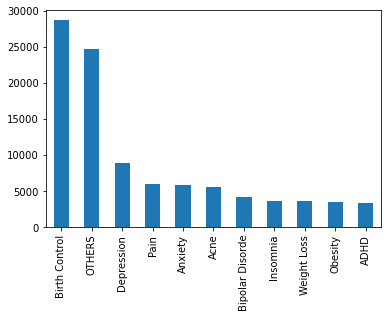

In [31]:
df_f['condition'].value_counts().plot(kind='bar')

In [37]:
y = df_f['condition']
y.shape

(97899,)

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_df=0.5)
X = vectorizer.fit_transform(df_f['norm_text'])
print(X.shape)

(97899, 796396)


In [39]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=25, stratify=y)

In [40]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)
X_train.shape, y_train.shape

((252593, 796396), (252593,))

In [41]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

clf = LinearSVC(random_state=25, class_weight='balanced', verbose=1)

clf.fit(X_train, y_train)

y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

print('Training accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test accuracy: ', accuracy_score(y_test, y_test_pred))

print(classification_report(y_test, y_test_pred))

[LibLinear]....*
optimization finished, #iter = 46
Objective value = -1296.279870
nSV = 27876
....*
optimization finished, #iter = 41
Objective value = -1572.483717
nSV = 22368
....*
optimization finished, #iter = 47
Objective value = -3978.205695
nSV = 46640
....*
optimization finished, #iter = 48
Objective value = -2617.992211
nSV = 42086
....*
optimization finished, #iter = 46
Objective value = -3790.782292
nSV = 38064
....*
optimization finished, #iter = 46
Objective value = -5709.392462
nSV = 62018
....*
optimization finished, #iter = 47
Objective value = -1917.764001
nSV = 27880
....*
optimization finished, #iter = 48
Objective value = -12247.695334
nSV = 103550
....*
optimization finished, #iter = 42
Objective value = -2781.383610
nSV = 48913
....*
optimization finished, #iter = 47
Objective value = -3233.180848
nSV = 34937
....*
optimization finished, #iter = 42
Objective value = -2713.903560
nSV = 47137
Training accuracy:  0.9993586520608251
Test accuracy:  0.8798774259448416


In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization


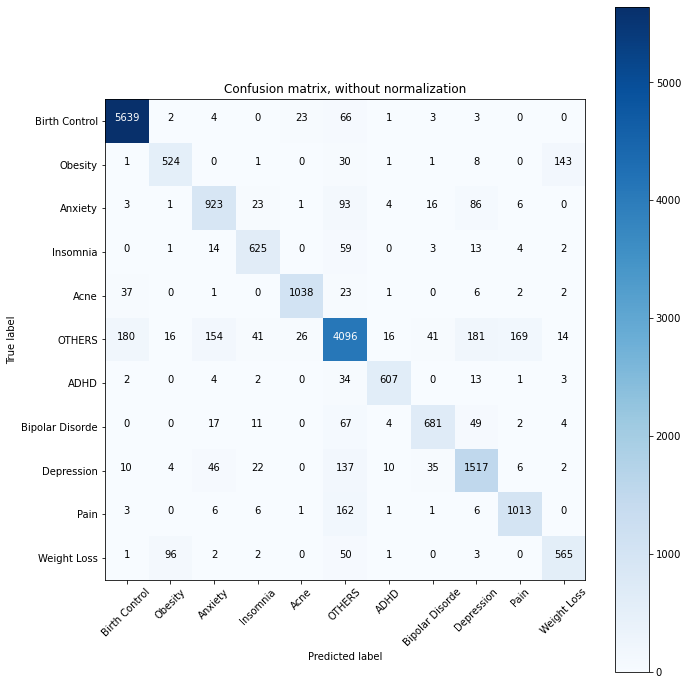

In [47]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, y_test_pred, labels=list(set(y_test)))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=list(set(y_test)), title='Confusion matrix, without normalization')